# Make Sure the ML Model Fitted Correctly

In [56]:
# Create a strategy using the trained model
# Backtest using timerange TRAINVAL, and pairs of trained model
# Make sure the profit graph is upwards (ofc coz we BT'ed in train and val date)

In [8]:
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

from pathlib import Path
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
import quantstats as qs
import os
import logging
import sys
import nest_asyncio

nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.nbtools")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.DEBUG)

# Freqtrade Imports
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.nbtools.preset import ConfigPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools.remote_utils import load_lightning_container
from freqtrade.nbtools.helper import parse_function_body
from freqtrade.nbtools import plotting, configs
from freqtrade.ml import lightning_utils

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
DATALOADER = DataLoader(max_n_datasets=5)

# Custom function
def string_templating(string: str, data: dict, strip_doublequotes=False):
    _string = deepcopy(string)
    """Replace [|key|] in string with data["key"] """
    for key, value in data.items():
        to_replace = "[|{}|]".format(key)
        if strip_doublequotes:
            to_replace = "\"[|{}|]\"".format(key)
        if to_replace not in string:
            raise Exception(f"Not found formatting with key '{key}'")
        _string = _string.replace(to_replace, str(value))
    return _string


def start_backtesting(strat_func, lightning_name: str, bt_type: str, version="latest"):
    PATH_LOCAL_DATADIR = PATH_MOUNT / "data"
    LIGHTNING_CONTAINER_NAME = lightning_name

    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version=version)
    
    if bt_type == "val":
        timerange = lightning_utils.get_timerange_trainval(lightning_container)
    elif bt_type == "opt":
        timerange = lightning_utils.get_timerange_opt(lightning_container)
    elif bt_type == "test":
        timerange = lightning_utils.get_timerange_test(lightning_container)
    else:
        raise Exception(f"Unknown BT type: {bt_type}")
    
    preset = ConfigPreset(
        name=LIGHTNING_CONTAINER_NAME,
        config_dict = configs.DEFAULT,
        path_data=PATH_LOCAL_DATADIR,
        timerange=timerange
    )
    preset.overwrite_config(pairs=lightning_container.config.pairs)

    strategy_code = string_templating(
        parse_function_body(strat_func),
        data={"LIGHTNING_CONTAINER_NAME": LIGHTNING_CONTAINER_NAME}
    )
    stats, summary = backtest(preset, strategy_code, dataloader=DATALOADER)
    return stats, summary, preset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: WANDB_SILENT=true


# Model Validation

In [6]:
"""
This strategy will backtested in Train and Validation date.
To make sure the model was fitted correctly, you need to know that you model is predicting accurately in this date.
Create the strategy that BUYS when the ML Model predicts the future is going to UP, and do the same for the sell.
The strategy doesn't need to be trend following, but the final backtest results must profitable steadily.
"""

def val_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="latest")        
    
    
    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {"0": 99}
        stoploss = -0.99
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe = lightning_container.predict(dataframe)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe['ml_2'] > 0.55,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            return dataframe
    """ End Strategy Code """

freqtrade.nbtools.remote_utils - Load LightningContainer version 'latest' of project: '5n20-catboostzero' - asset_name: '5n20-catboostzero'.
freqtrade.nbtools.remote_utils - WARNING: You are using the LATEST version of LightningContainer asset!
freqtrade.nbtools.preset.config_preset - Preparing ConfigPreset for `5n20-catboostzero`
freqtrade.nbtools.preset.base_preset - Setting config for 5n20-catboostzero ...
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 62 pairs)
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to C:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20210609-20210710
freqtrade.nbtools.backtest - Backtesting...
freqtrade.nbtools.remote_utils - Load LightningContainer version 'latest' of project: '5n20-catboostzero' - asset_name: '5n20-catboostzero'.
freqtrade.nbtools.remote_utils - WARNING: You are using the LATEST version of LightningContainer asset!
freqtrade.nb

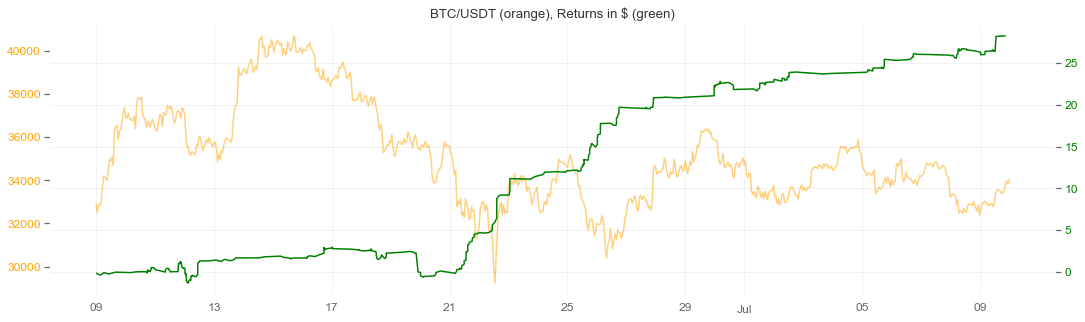

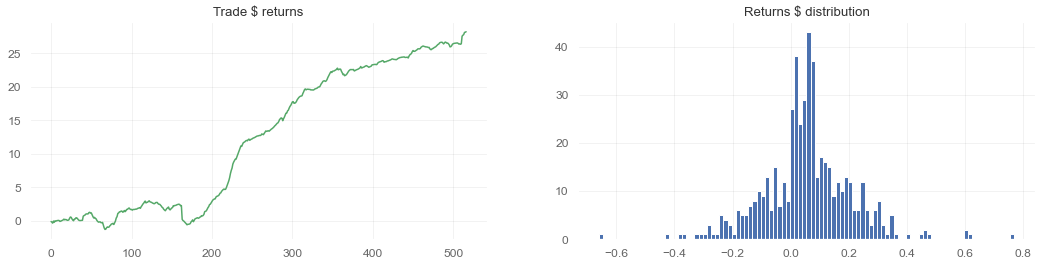

,Portfolio Summary
Min Balance,-1.29
Max Balance,28.22
End Balance,28.22
Trades,517.00
Avg. Profit %,0.36
Avg. Profit $,0.05
Biggest Profit $,1.14
Biggest Loss $,-2.06


In [9]:
MODEL_NAME = "5n20-catboostzero"
MODEL_VER = "latest"

stats, summary, preset = start_backtesting(val_strategy, MODEL_NAME, "val", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)

# Model x Strategy Optimization

In [12]:
""" 
In this phase, tinker your strategy until you get the "Sweet Spot"!
"""

def opt_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="latest")        
    
    
    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {"0": 99}
        stoploss = -0.99
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe["ema"] = ta.EMA(dataframe, timeperiod=200)
            dataframe = lightning_container.predict(dataframe)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe['close'] > dataframe['ema'],
                dataframe['ml_2'] > 0.55,
                dataframe['ml_1'] < 0.55,
                dataframe['ml_0'] < 0.55,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            return dataframe
    """ End Strategy Code """

freqtrade.nbtools.remote_utils - Load LightningContainer version 'latest' of project: '5n20-catboostzero' - asset_name: '5n20-catboostzero'.
freqtrade.nbtools.remote_utils - WARNING: You are using the LATEST version of LightningContainer asset!
freqtrade.nbtools.preset.config_preset - Preparing ConfigPreset for `5n20-catboostzero`
freqtrade.nbtools.preset.base_preset - Setting config for 5n20-catboostzero ...
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 62 pairs)
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to C:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20210711-20210726
freqtrade.nbtools.backtest - Backtesting...
freqtrade.nbtools.remote_utils - Load LightningContainer version 'latest' of project: '5n20-catboostzero' - asset_name: '5n20-catboostzero'.
freqtrade.nbtools.remote_utils - WARNING: You are using the LATEST version of LightningContainer asset!
freqtrade.nb

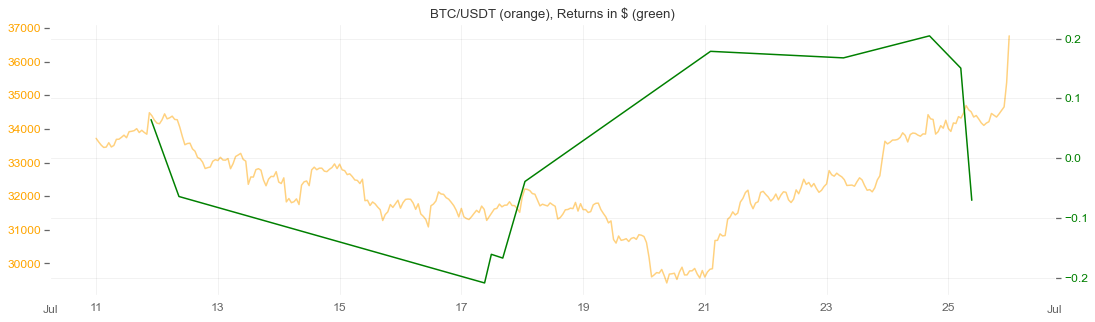

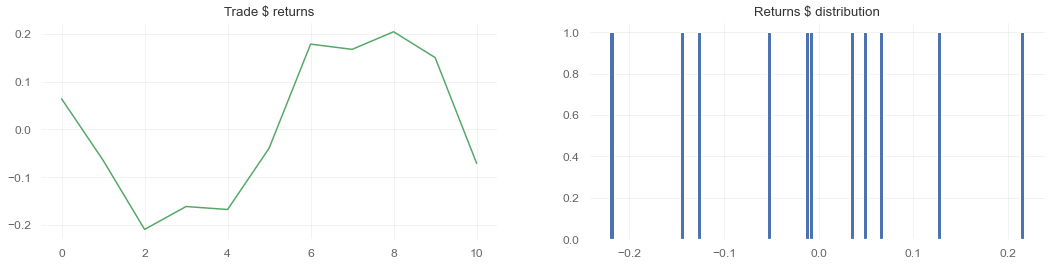

,Portfolio Summary
Min Balance,-0.21
Max Balance,0.20
End Balance,-0.07
Trades,11.00
Avg. Profit %,-0.04
Avg. Profit $,-0.01
Biggest Profit $,0.22
Biggest Loss $,-0.22


In [13]:
stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "opt", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)

# Unbiased Backtesting

freqtrade.nbtools.remote_utils - Load LightningContainer version 'latest' of project: '5n20-catboosttest' - asset_name: '5n20-catboosttest'.
freqtrade.nbtools.remote_utils - WARNING: You are using the LATEST version of LightningContainer asset!
freqtrade.nbtools.preset.config_preset - Preparing ConfigPreset for `5n20-catboosttest`
freqtrade.nbtools.preset.base_preset - Setting config for 5n20-catboosttest ...
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 5 pairs)
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to C:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20210712-20210810
freqtrade.nbtools.backtest - Backtesting...
freqtrade.nbtools.remote_utils - Load LightningContainer version 'latest' of project: '5n20-catboosttest' - asset_name: '5n20-catboosttest'.
freqtrade.nbtools.remote_utils - WARNING: You are using the LATEST version of LightningContainer asset!
freqtrade.nbt

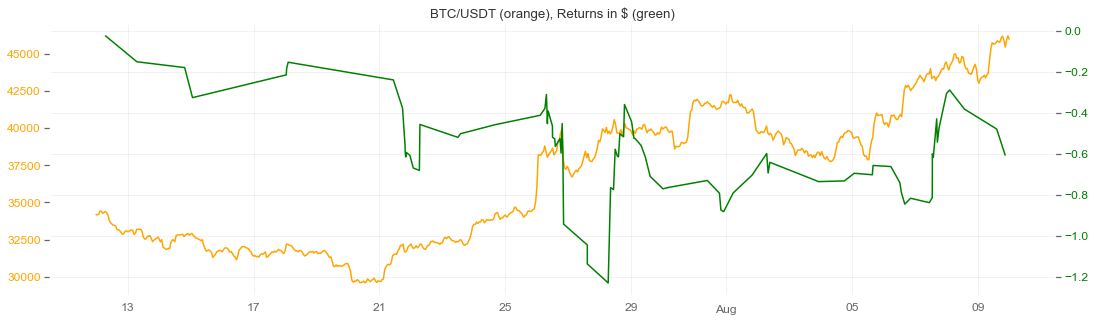

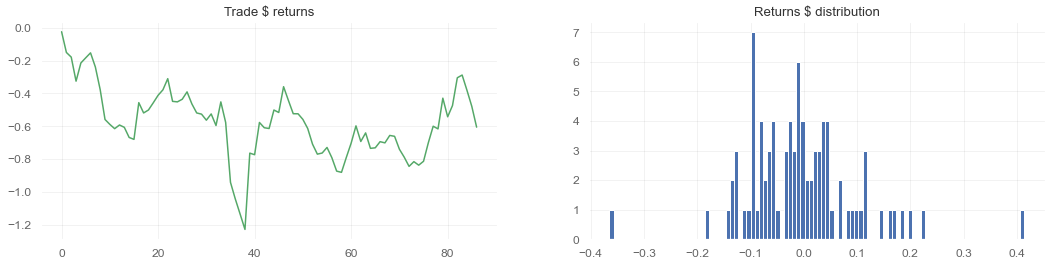

,Portfolio Summary
Min Balance,-1.23
Max Balance,-0.02
End Balance,-0.61
Trades,87.00
Avg. Profit %,-0.05
Avg. Profit $,-0.01
Biggest Profit $,0.46
Biggest Loss $,-0.36


In [55]:
""" 
Just run once every "Sweet Spot" you got!
"""
stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "test", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)